# Implicit Likelihood Inference - 1 mois 1 labo

Author: Sacha Guerrini (sacha.guerrini@cea.fr)

Credit image: Siddharth Mishra-Sharma (smsharma@mit.edu)

![CosmoStat logo](https://www.cosmostat.org/wp-content/uploads/2017/07/CosmoStat-Logo_WhiteBK.jpg)

In [34]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch

try:
    import sbi
except:
    %pip install sbi -q

from sbi.inference import NPE, SNLE, NRE
from sbi.inference.posteriors import MCMCPosterior
from sbi.inference.potentials import likelihood_estimator_based_potential
from sbi.utils import BoxUniform

try:
    import sbibm
except:
    %pip install sbibm -q

try:
    from getdist import MCSamples, plots
except:
    %pip install getdist -q

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on {'GPU' if device.type=='cuda' else 'CPU'}")

Running on GPU


## 1. Theoretical introduction to Implicit Likelihood Inference

The inference of parameters $\theta$ given some data is ubiquitous across different fields of science (e.g. astrophysics, epidemiology,...). In those problems, the goal is not only to estimate the parameters but also to propagate the uncertainty on the data to the parameters. A way to think about such problems is in terms of distribution. Bayesian statistics relies on Bayes theorem:

$$
p(\theta| x) \propto p(x|\theta)p(\theta)
$$

where:
- $p(x|\theta)$ is the likelihood function. It corresponds to the distribution of the data points $x$ given some parameters $\theta$.
- $p(\theta)$ is the prior distribution of the parameters $\theta$. It contains constraints on the possible values of the parameters $\theta$ and can also encapsulate knowledge on the parameters.
- $p(\theta|x)$ is the posterior distribution of the parameters $\theta$ given some data $x$. The goal of our inference problem is to accurately estimate this distribution.

The figure below summarizes those concepts:

<img src=./likelihood.png alt= “” width=800>

### 1.1 Inference in cosmology

In cosmology, cosmological parameters are constrained estimating posteriors of the cosmological parameters given some data. In cosmology, the data relates to a signal that relates to a cosmological probe. For example, the distribution of mass in the universe bends light in a *coherent* way. We refer to this effect as *weak gravitational lensing*. The correlation in the shape of galaxies carries information on the unobserved underlying large-scale structures (filaments, voids and galaxy clusters). Those correlations can thus be modeled and used to constrain the cosmological parameters.

### 1.2 Inference 101

The vanilla approach to perform inference is to assume a closed form of the likelihood. Various forms can be considered depending on the problem at hand. A standard assumption in cosmology is to use a *Gaussian likelihood*. This assumption is motivated by the ergodic principle that applies in cosmology due to the *cosmological principle* which states that on region of the sky separated by large scales sample independant realisations of our summary statistics/data $x$. Averaging a large number of independant and identically distributed samples yields a Gaussian distribution according to the Central Limit Theorem (CLT). A *Gaussian likelihood* writes:

$$
p(x|\theta) \propto (x_{\rm obs}-x_{\rm model}(\theta))^T \Sigma^{-1}(\theta)(x_{\rm obs}-x_{\rm model}(\theta))
$$

where $x_{\rm model}(\theta)$ is the prediction of the model for the given parameters $\theta$ and $\Sigma(\theta)$ is the covariance of the data vector. It is possible to sample from the posterior distribution $p(\theta|x)$ using Markov Chain Monte Carlo (MCMC) algorithms (see e.g. https://arxiv.org/pdf/2001.06249 for a review and https://chi-feng.github.io/mcmc-demo/ for a demo).

This method has been and is still widely used in cosmology. However, it shows some limitations with regard to the challenges that upcoming Stage-IV surveys such as *Euclid* or *LSST* will bring.

#### Limitations for cosmological analysis

- MCMC algorithms are mostly sequential. The amount and high quality data of Stage-IV surveys increase the computation time needed to estimate the model $x_{\rm model}$ for given parameters $\theta$. In addition, the dimensionality of the parameter space to sample from increases as some effects cannot be neglected. Because of the *curse of dimensionality* the MCMC chains take longer to converge. Overall, estimating parameters using the standard methodology can take up to a week.

- The *Gaussian likelihood* assumption relies on the ergodic principle that poorly applies on some scales (small and large). It is always possible to test the Gaussianity of the likelihood at those scales but it is not obvious how to deal with it. Moreover, the community has growing interest for *higher-order statistics* that capture non-Gaussian information from cosmological probes. However, little is known on the likelihood of those statistics and it is sometimes not possible to model those statistics from first principles.


For those reasons, the community started to have interest in new inference methods using Artificial Intelligence to perform inference. Those methods are usually refered to as *Likelihood-Free Inference*, *Simulation-Based Inference* or *Implicit Likelihood Inference*.


### 1.3 Implicit Likelihood Inference

**Disclaimer: There are subtle and technical difference between what we call Simulation-Based Inference and Explicit/Implicit Likelihood Inference. For simplicity and clarity, I will here assume that they all relate to the same thing but I encourage the interested reader to check the litterature for a better understanding of the differences between those terminologies.**

*Implicit Likelihood Inference* (ILI) is a change of paradigm using both forward and generative models to perform the inference. The situation is the following. In our toolbox, we know how to create realistic simulations of the thing we are trying to measure. In cosmology, we indeed rely on N-body simulations to reproduce the overdensity field (large-scale structures) and we know (up to a certain level of precision) how to use this overdensity field to reproduce cosmological observable that "look like" our real data. However, this tool is not used in Inference 101, albeit for validation purposes. The idea is to replace theoretical modelling of the data we are observing $x_{\rm model}(\theta)$ by a (stochastic) simulation that allows you to sample from the likelihood $\tilde{x} \sim p(x|\theta)$. Estimating the posterior $p(\theta|x)$ could thus be formulated as follows:

*What is the set of parameters $\theta$ that produce, using the simulator, fake observations that "look like" my real observation?*

In inference 101, the likelihood was explicitely specified with an analytical form. Now, the stochastic simulator allows us to sample from a likelihood that became *implicit*, hence the name. In principle, arbtirarily complex effect can be accounted for in the forward model without worrying whether we know how to model them theoretically. Nevertheless, this methodology relies on a strong assumption: **the simulator produces observations that are realistic enough**.

![SBI schematic view](https://sbi-dev.github.io/sbi/v0.23.2/static/goal.png)

At that stage, we have an implicit likelihood $p(x|\theta)$ that we can sample from but it is intractable. That is where *generative models* using Artificial Intelligence (AI) are powerful tools. Generative models are models whose target are distributions. *Normalizing Flows* (NF) are neural-network based generative models that act as a series of bijective transformations of a simple distribution (e.g. a unit Gaussian) into a complex one.

![Normalizing flow scheme](https://miro.medium.com/v2/resize:fit:1400/0*NH5VVAcdtUkQKTkF.png)

NFs are trained by minimizing the Kullback-Leibler (KL) divergence between a target distribution $p(x)$ and the distribution $q_{\varphi}(x)$ emulated by the NF with $\varphi$ the weights of the neural network.

$$
D_{\rm KL}(p(x)|q_{\varphi}(x)) = \int p(x)\log\left( \frac{p(x)}{q_{\varphi}(x)}\right)dx
$$

Indeed, the KL divergence is 0 for two identical distributions and positive otherwise. It can be decomposed in a term of entropy of the distribution $p(x)$, $\mathbb{H}(p)$, and a term that depends on the weight $\varphi$. Minimizing the KL divergence is thus equivalent to minimizing the negative log-probability:

$$
\mathcal{L}(\varphi) = \mathbb{E}_{p(x)}\left[ -\log(q_{\varphi}(x))\right]
$$

With this latter loss, the only requirement is to be able to sample from the target distribution. That's great, because this is exactly what we have with our simulator!

### 1.4 Summary

As a summary, here are the following steps to perform implicit likelihood inference:

1. Choose a prior for your parameters $p(\theta)$.
2. Build a simulator to sample realistic observations $p(x|\theta)$.
3. Create a dataset composed of pairs $(\theta, x)$.
4. Use this dataset to train a normalizing flow to emulate a target distribution (See next section)
5. Sample the posterior $p(\theta, x)$.

And here is a compilation of advantages and drawbacks of ILI:

| **Advantage** | **Drawbacks** |
|--------------|--------------|
| Fast to run on GPU | NFs are black box  |
| No assumption on the form of the likelihood | Very sensitive to misspecifications  |
| Don't model your systematics; forward model it! |  |

## 2. First example: Gaussian linear likelihood

[Lueckmann et al.](https://arxiv.org/abs/2101.04653) made a benchmark of ILI with various problems. We will use the library `sbibm` that allows to use the same simulator than in their benchmark. Many tasks are available:

In [3]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'bernoulli_glm',
 'gaussian_linear',
 'gaussian_linear_uniform',
 'slcp',
 'two_moons',
 'sir',
 'lotka_volterra',
 'slcp_distractors',
 'bernoulli_glm_raw']

We will first explore a simple example the `gaussian_linear_uniform`:

- Prior: $\mathcal{U}(-1, 1)$
- Simulator: $x|\theta \sim \mathcal{N}(x|m_{\theta}=\theta, \Sigma=0.1 \odot I)$
- $\theta \in \mathbb{R}^{10}, x \in \mathbb{R}^{10}$

In [4]:
#Let's first load the task
task = sbibm.get_task('gaussian_linear_uniform')
prior = task.get_prior()  #Returns an object that allows to sample from the prior
simulator = task.get_simulator()  #Returns the simulator function
reference_samples = task.get_reference_posterior_samples(num_observation=1)  #Returns the reference samples
observation = task.get_observation(num_observation=1) #Returns the observation
truth = task.get_true_parameters(num_observation=1).flatten() #Returns the true parameters

dim_theta = truth.shape[0]
dim_obs = observation.shape[1]

print(f"Dimension of theta: {dim_theta}")
print(f"Dimension of observation: {dim_obs}")
print(f"True parameters: {truth}")

Dimension of theta: 10
Dimension of observation: 10
True parameters: tensor([-0.9527, -0.1482,  0.9824,  0.4132,  0.9904, -0.7402,  0.7862,  0.0438,
        -0.6262, -0.7651])


Removed no burn in


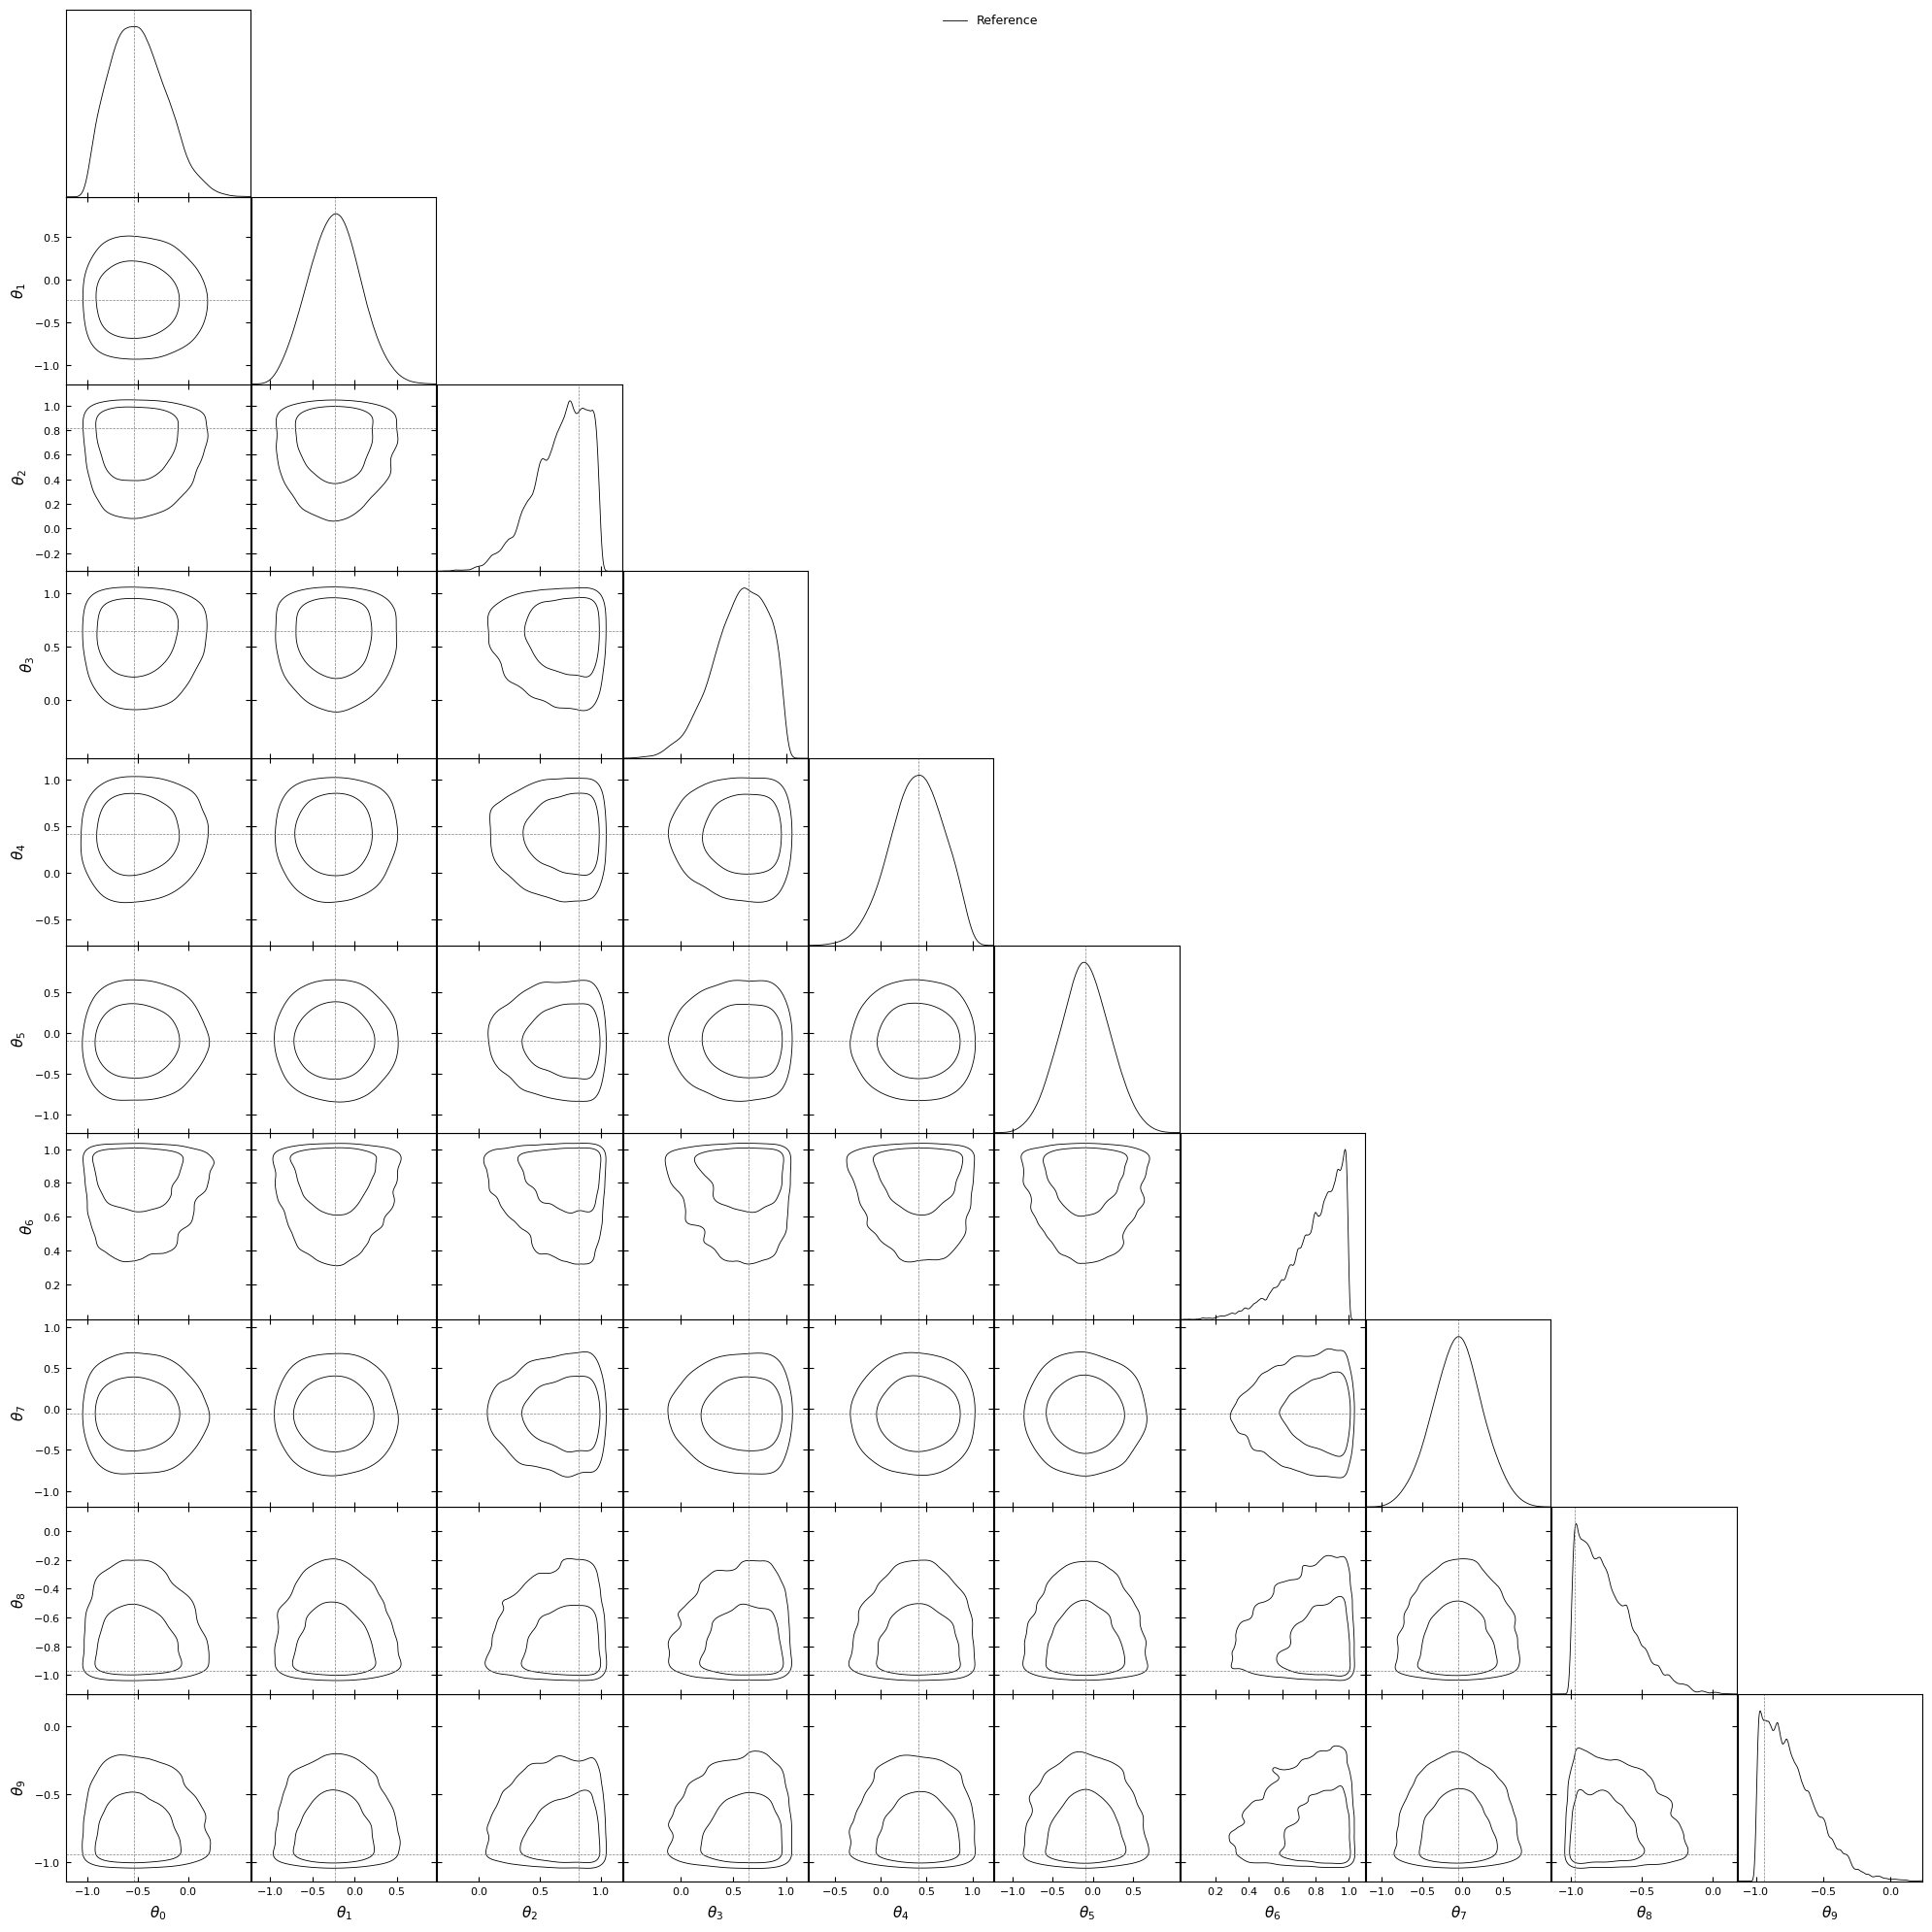

In [5]:
#Let's have a look at the target, we will plot
#distributions using getdist
labels = [rf'\theta_{i}' for i in range(10)]

reference_samples_gd = MCSamples(samples=reference_samples.numpy(), names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd],
                filled=[False],
                legend_labels=["Reference"],
                line_args=[
                    {'color': 'black'},
                ],
                contour_colors=['black'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()


To train our NFs, we first need a training set drawn from the simulator.

In [6]:
train_set_size = 10_000
theta_train = prior(num_samples=train_set_size)
x_train = simulator(theta_train)

### 2.1 Neural Posterior Estimation (NPE)

*Neural Posterior Estimation* (NPE) is a first approach of implicit likelihood where the samples $(\theta, x) \sim p(\theta, x)$ are used to directly estimate the posterior. The target density of the normalizing flow is the distribution $p(\theta|x)$. Contrary to what was introduced in the first part, the distribution is conditioned on the observed data $x$. The NF learns thus learns a map from the observations to the space of distributions in the parameter space:

$$
q_{\varphi} : x \longrightarrow p(\theta|x)
$$

![NPE summary](https://github.com/smsharma/sbi-lecture-mit/blob/main/assets/npe.png?raw=1)

Using NPE, the posterior distribution is directly learned so you can sample from it and compute the log-probability of any parameters $\tilde{\theta}$. The prior distribution is the one used to create the training set. It can be an issue in practice as the inference can sometime be prior dominated. Using costly simulations, NPE does not allow to test prior effects efficiently.

Let's look at how it works in practice. In this notebook, we use the standard `sbi` package based on `torch` to implement and train the neural networks. (See the documentation [here](https://sbi-dev.github.io/sbi/v0.23.2/))

In [8]:
#Let's first create a prior object
prior_sbi = BoxUniform(low=-torch.ones(10), high=torch.ones(10), device=device)

In [10]:
#We then create an object to perform NPE
#In torch, if you want to use the GPU, you have to specify
#the device on which the data will be stored
inference = NPE(prior=prior_sbi, device=device)
#Add the simulations to the object
theta_train = theta_train.to(device)
x_train = x_train.to(device)
inference = inference.append_simulations(theta=theta_train, x=x_train)

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


In [11]:
#Train!!!
density_estimator = inference.train()

 Neural network successfully converged after 115 epochs.

In [12]:
#You can then recover the posterior distribution
posterior = inference.build_posterior()
print(posterior)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


The learned posterior is said to be *amortized* as it returns a posterior for any observation $x$ provided. Let's try to use the observation provided by `sbibm` and check if we recover the correct distribution.

In [14]:
npe_samples = posterior.sample((10_000,), x=observation.to(device))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
npe_samples = npe_samples.cpu().numpy()

Removed no burn in


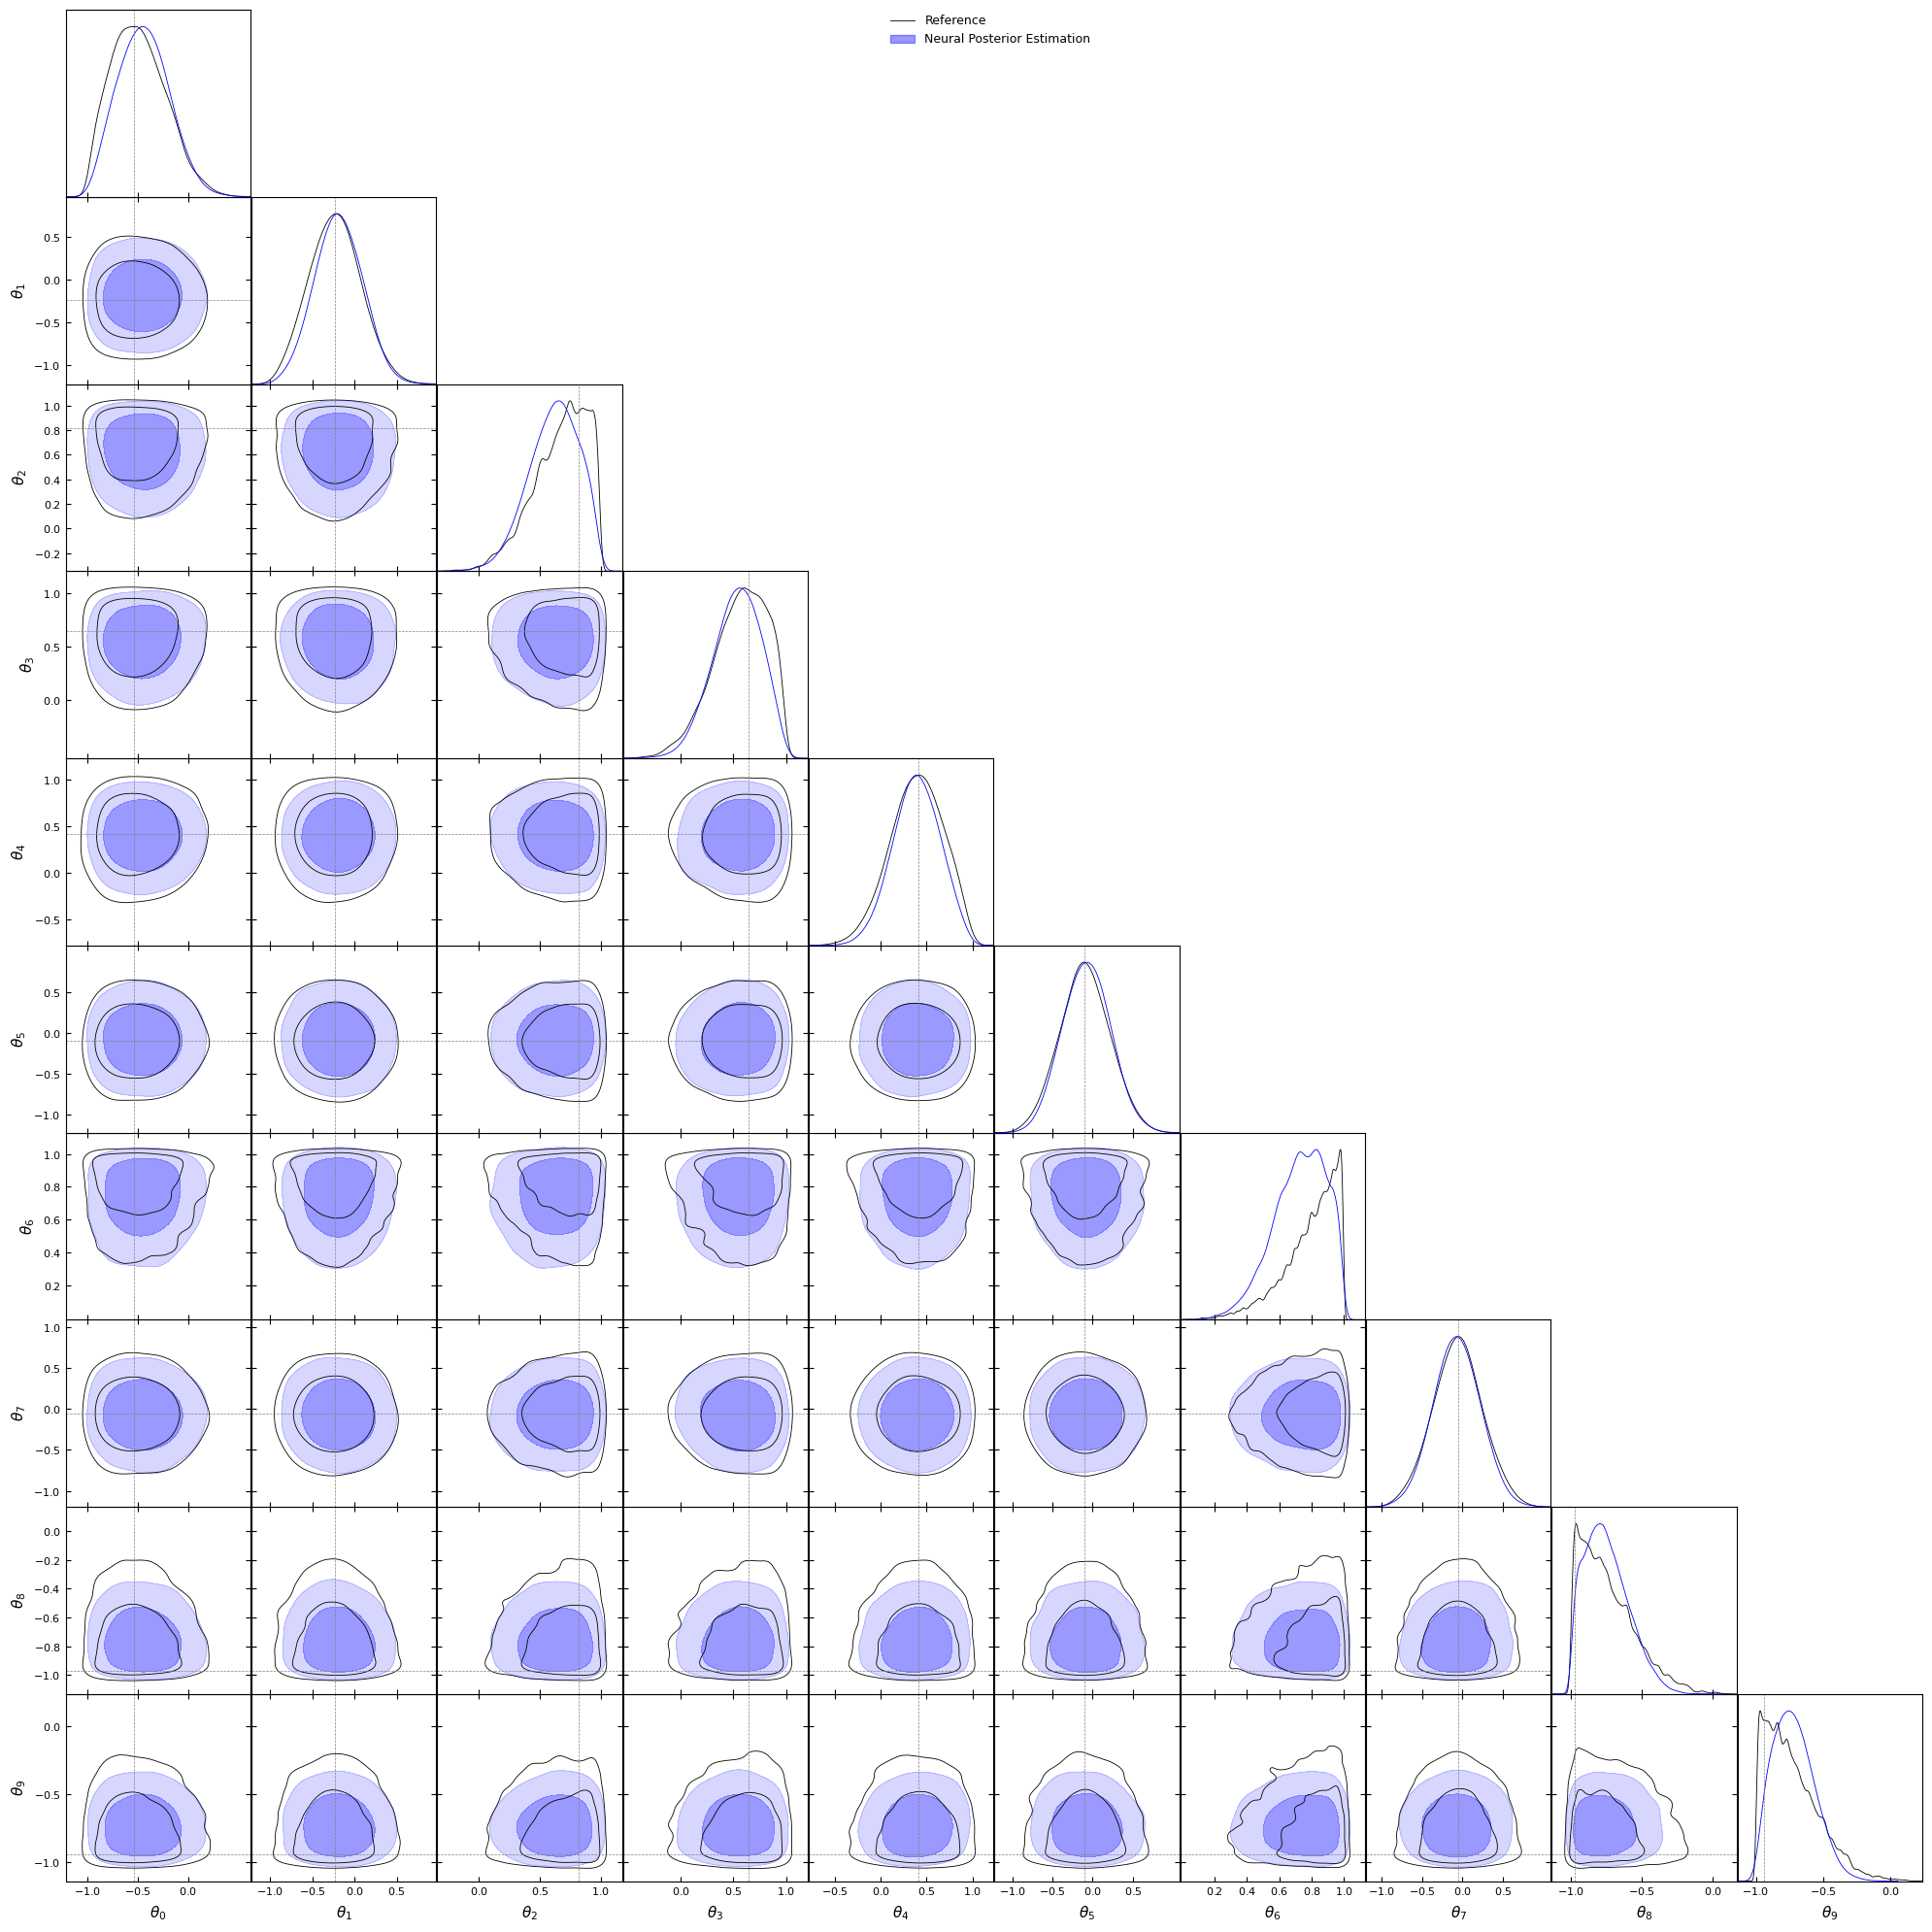

In [17]:
npe_samples_gd = MCSamples(samples=npe_samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "Neural Posterior Estimation"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'}
                ],
                contour_colors=['black', 'blue'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

This looks very nice!

### 2.2 Neural Likelihood Estimation (NLE)

Another approach is to learn the likelihood $p(x|\theta)$ rather than the posterior $p(\theta|x)$. We call this approach *Neural Likelihood Estimation* (NLE). It is technically completely similar to NPE but where the sampled and conditioned variables are exchanged. It has a few important differences though:

- NLE requires an additional sampling step using e.g. MCMC.
- The prior used for the sampling step can be different from the prior used to draw the training set. The user can thus check if there are volume effects.
- The log-probability of the posterior $p(\theta|x)$ cannot be computed directly.
- For some summary statistics, the size of the data vector can be very large. The target distribution becomes intractable for NFs and it is usual to use compression methods that we will not describe in this notebook to cope with high-dimensional summary statistics.

This approach is particularly interesting in cosmology as it allows to verify if the likelihood is Gaussian or not (see e.g. [von Wietersheim-Kramsta et al.](https://arxiv.org/abs/2404.15402)) and have a comparison closer to "apple-to-apple" with the standard methodology to perform inference.

Let's implement it!

In [18]:
#As previously, let's create an SNLE object
inference_nle = SNLE(prior=prior_sbi, device=device)    

In [19]:
#Let's add our training set
inference_nle = inference_nle.append_simulations(theta=theta_train, x=x_train)

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


In [20]:
#Train!!!
density_estimator_nle = inference_nle.train()

 Neural network successfully converged after 70 epochs.

In [33]:
#We then create an MCMC posterior to sample from the posterior
posterior_nle = inference_nle.build_posterior(
    mcmc_method="slice_np_vectorized",
    mcmc_parameters={"num_chains": 20,
                    "thin": 1}
)
print(posterior_nle)

In [34]:
#Sample and grab a coffee this can take a while
nle_samples = posterior_nle.sample((5_000,), x=observation.to(device))

Running vectorized MCMC with 20 chains:   0%|          | 0/10000 [00:00<?, ?it/s]

In [35]:
nle_samples = nle_samples.cpu().numpy()

Note that the likelihood is differentiable so it is possible to use more advanced samplers relying on the gradient of the likelihood such as HMC or NUTS.

Let's compare NPE and NLE with reference samples!

Removed no burn in


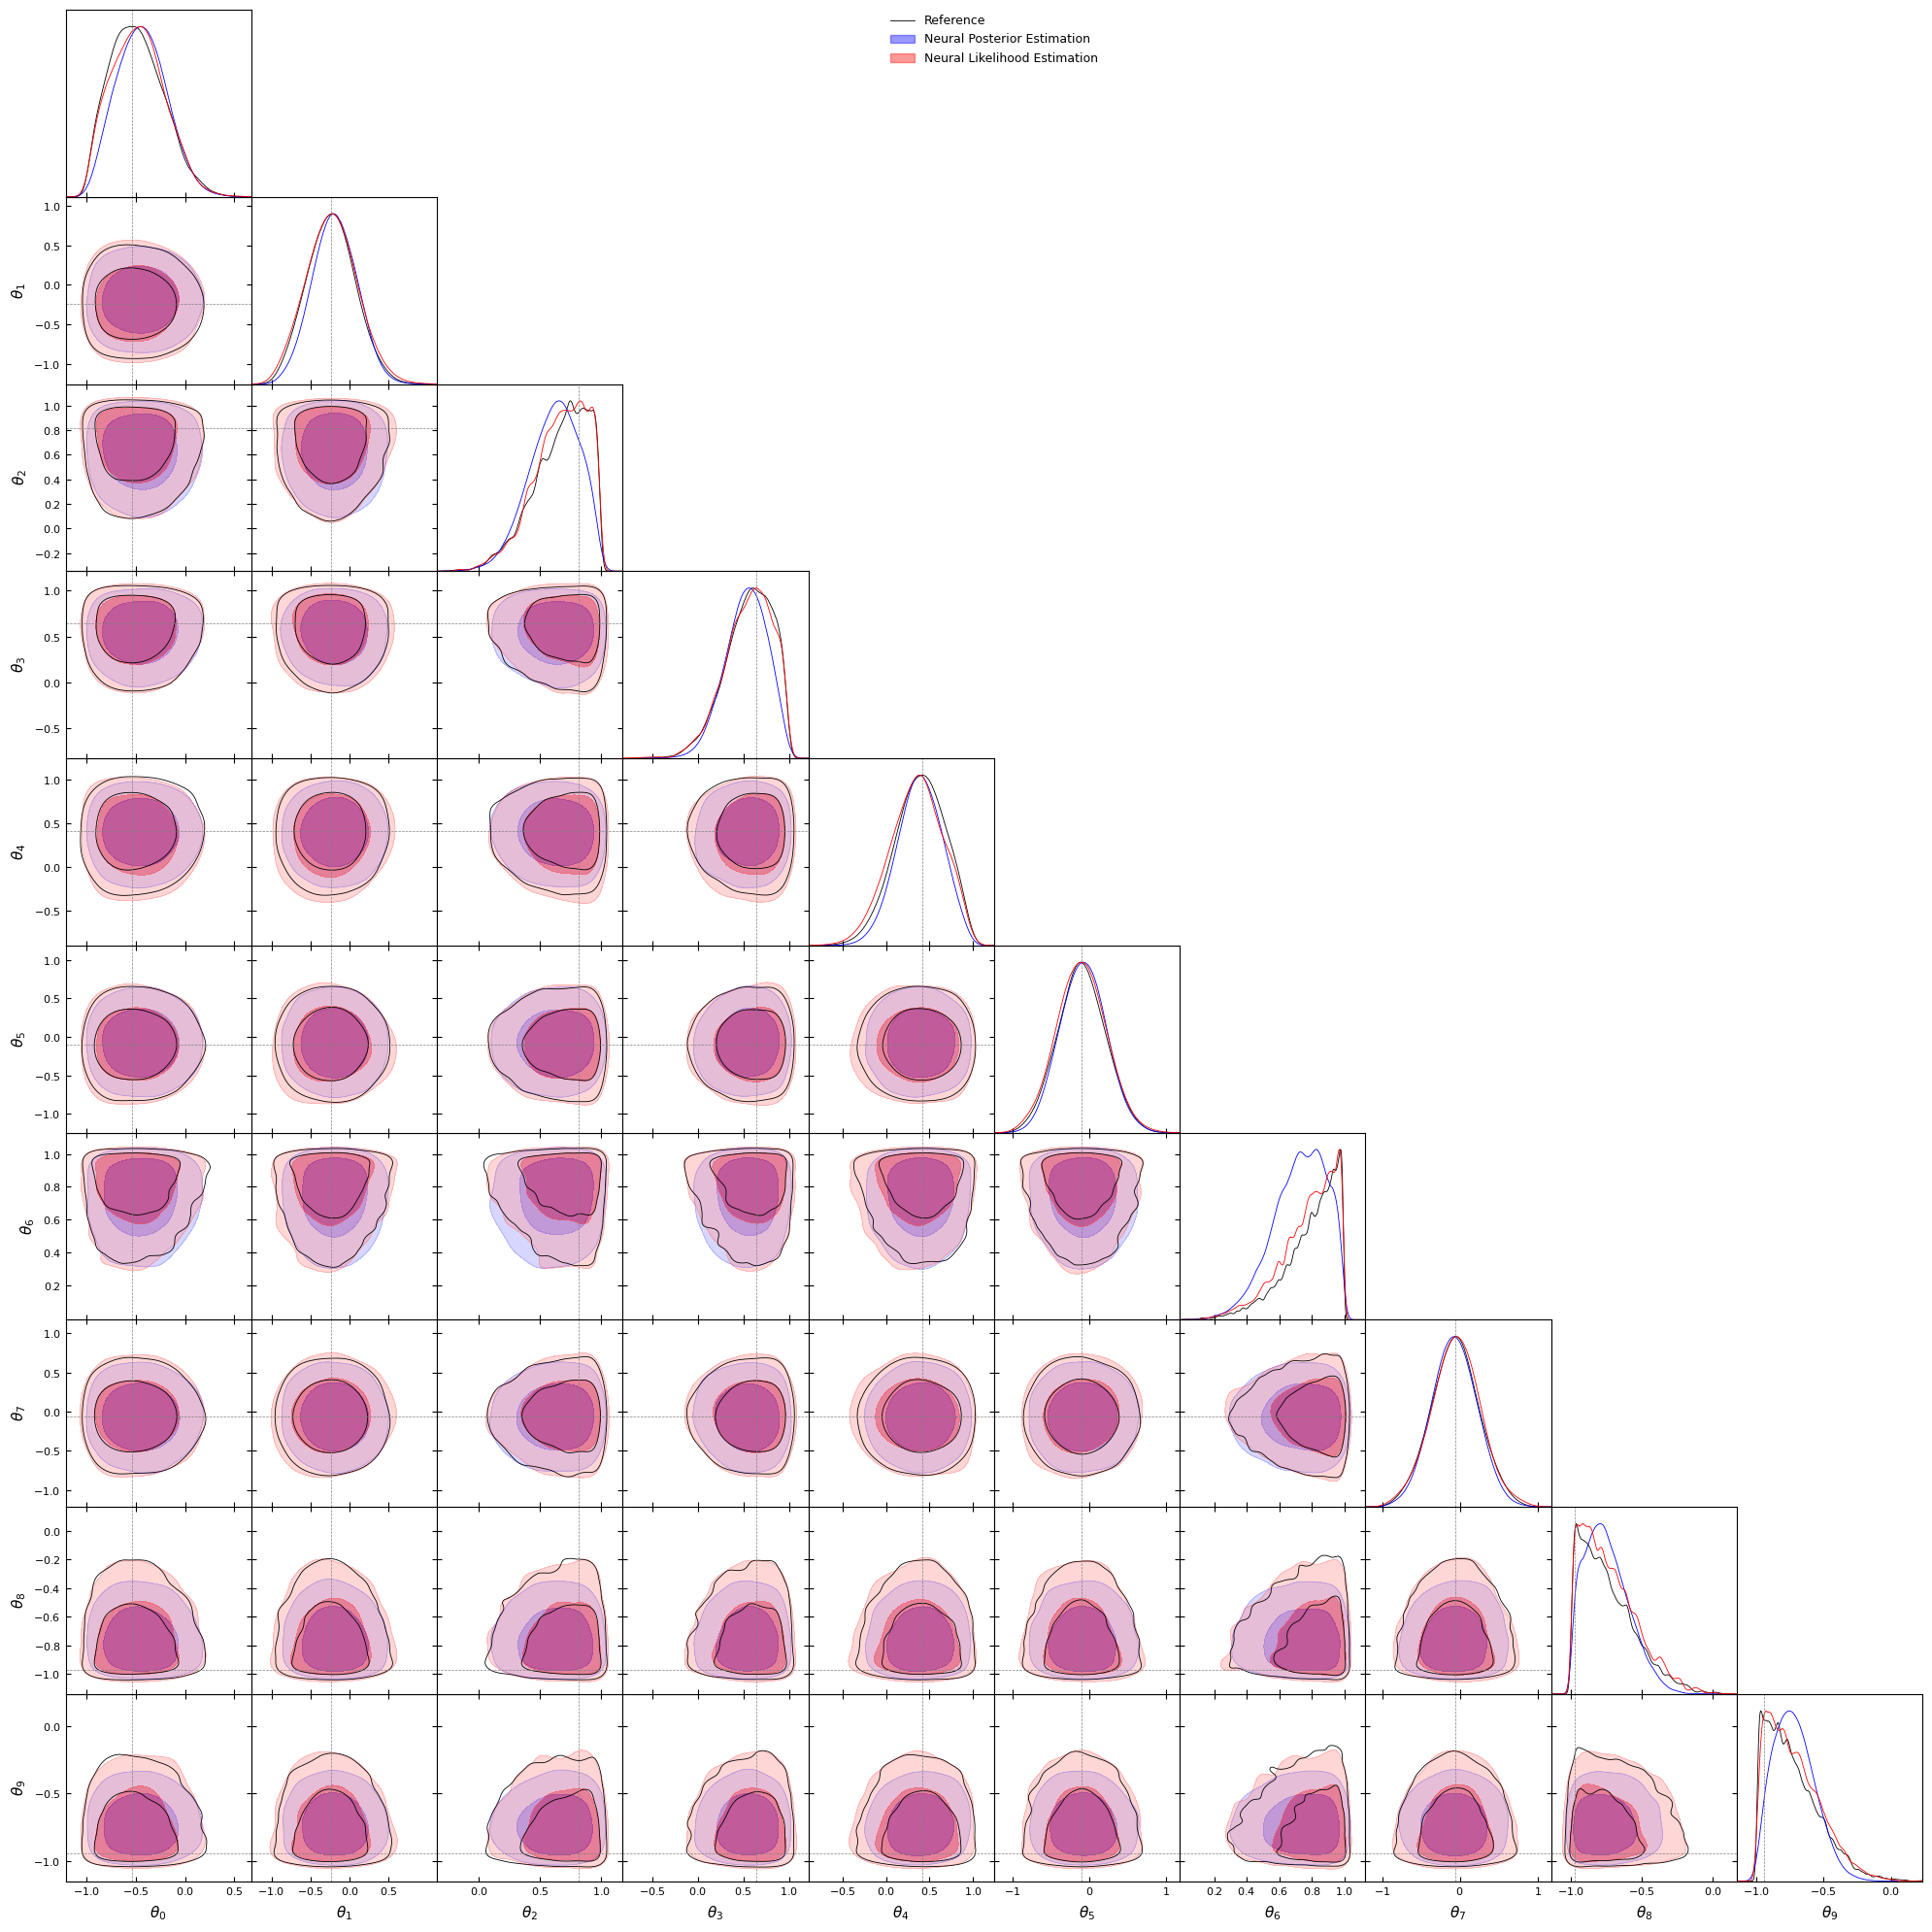

In [36]:
nle_samples_gd = MCSamples(samples=nle_samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd, nle_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "Neural Posterior Estimation", "Neural Likelihood Estimation"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

This works really nice as well!

## 2.3 Neural Ratio Estimation (NRE)

A last approach is to estimate the ratio $p(x|\theta)/p(x)$ which carries the information needed to sample from the posterior using MCMC. Indeed, the transition probability to a current parameter $\theta_t$ to a proposed parameter $\tilde{\theta}$ depends on the ratio of the posterior:

$$
\frac{p(\tilde{\theta}|x)}{p(\theta_t|x)}= \frac{p(\tilde{\theta})p(x|\tilde{\theta})}{p(\theta_t)p(x|\theta_t)}
$$

The ratio can estimated by training a classifier to recognize samples that are not sampled from the joint distribution $p(x, \theta)$. It can be shown that the ratio corresponds to he logits of the classifier.

![NRE schema](https://github.com/smsharma/sbi-lecture-mit/blob/main/assets/nre.png?raw=1)

Let's implement it!

In [38]:
# Create an inference object
inference_nre = NRE(prior=prior_sbi, device=device)

In [39]:
#Let's add our training set
inference_nre = inference_nre.append_simulations(theta=theta_train, x=x_train)

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


In [40]:
#Train!!! Note that it is way faster. Classifiers are not as heavy as NFs
density_estimator_nre = inference_nre.train()

 Neural network successfully converged after 109 epochs.

In [41]:
#Create an MCMC posterior
posterior_nre = inference_nre.build_posterior(
    mcmc_method="slice_np_vectorized",
    mcmc_parameters={"num_chains": 20,
                    "thin": 1}
)
print(posterior_nre)

Posterior p(θ|x) of type MCMCPosterior. It provides MCMC to .sample() from the posterior and can evaluate the _unnormalized_ posterior density with .log_prob().


In [42]:
#Let's gather samples
nre_samples = posterior_nre.sample((5_000,), x=observation.to(device))

Running vectorized MCMC with 20 chains:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


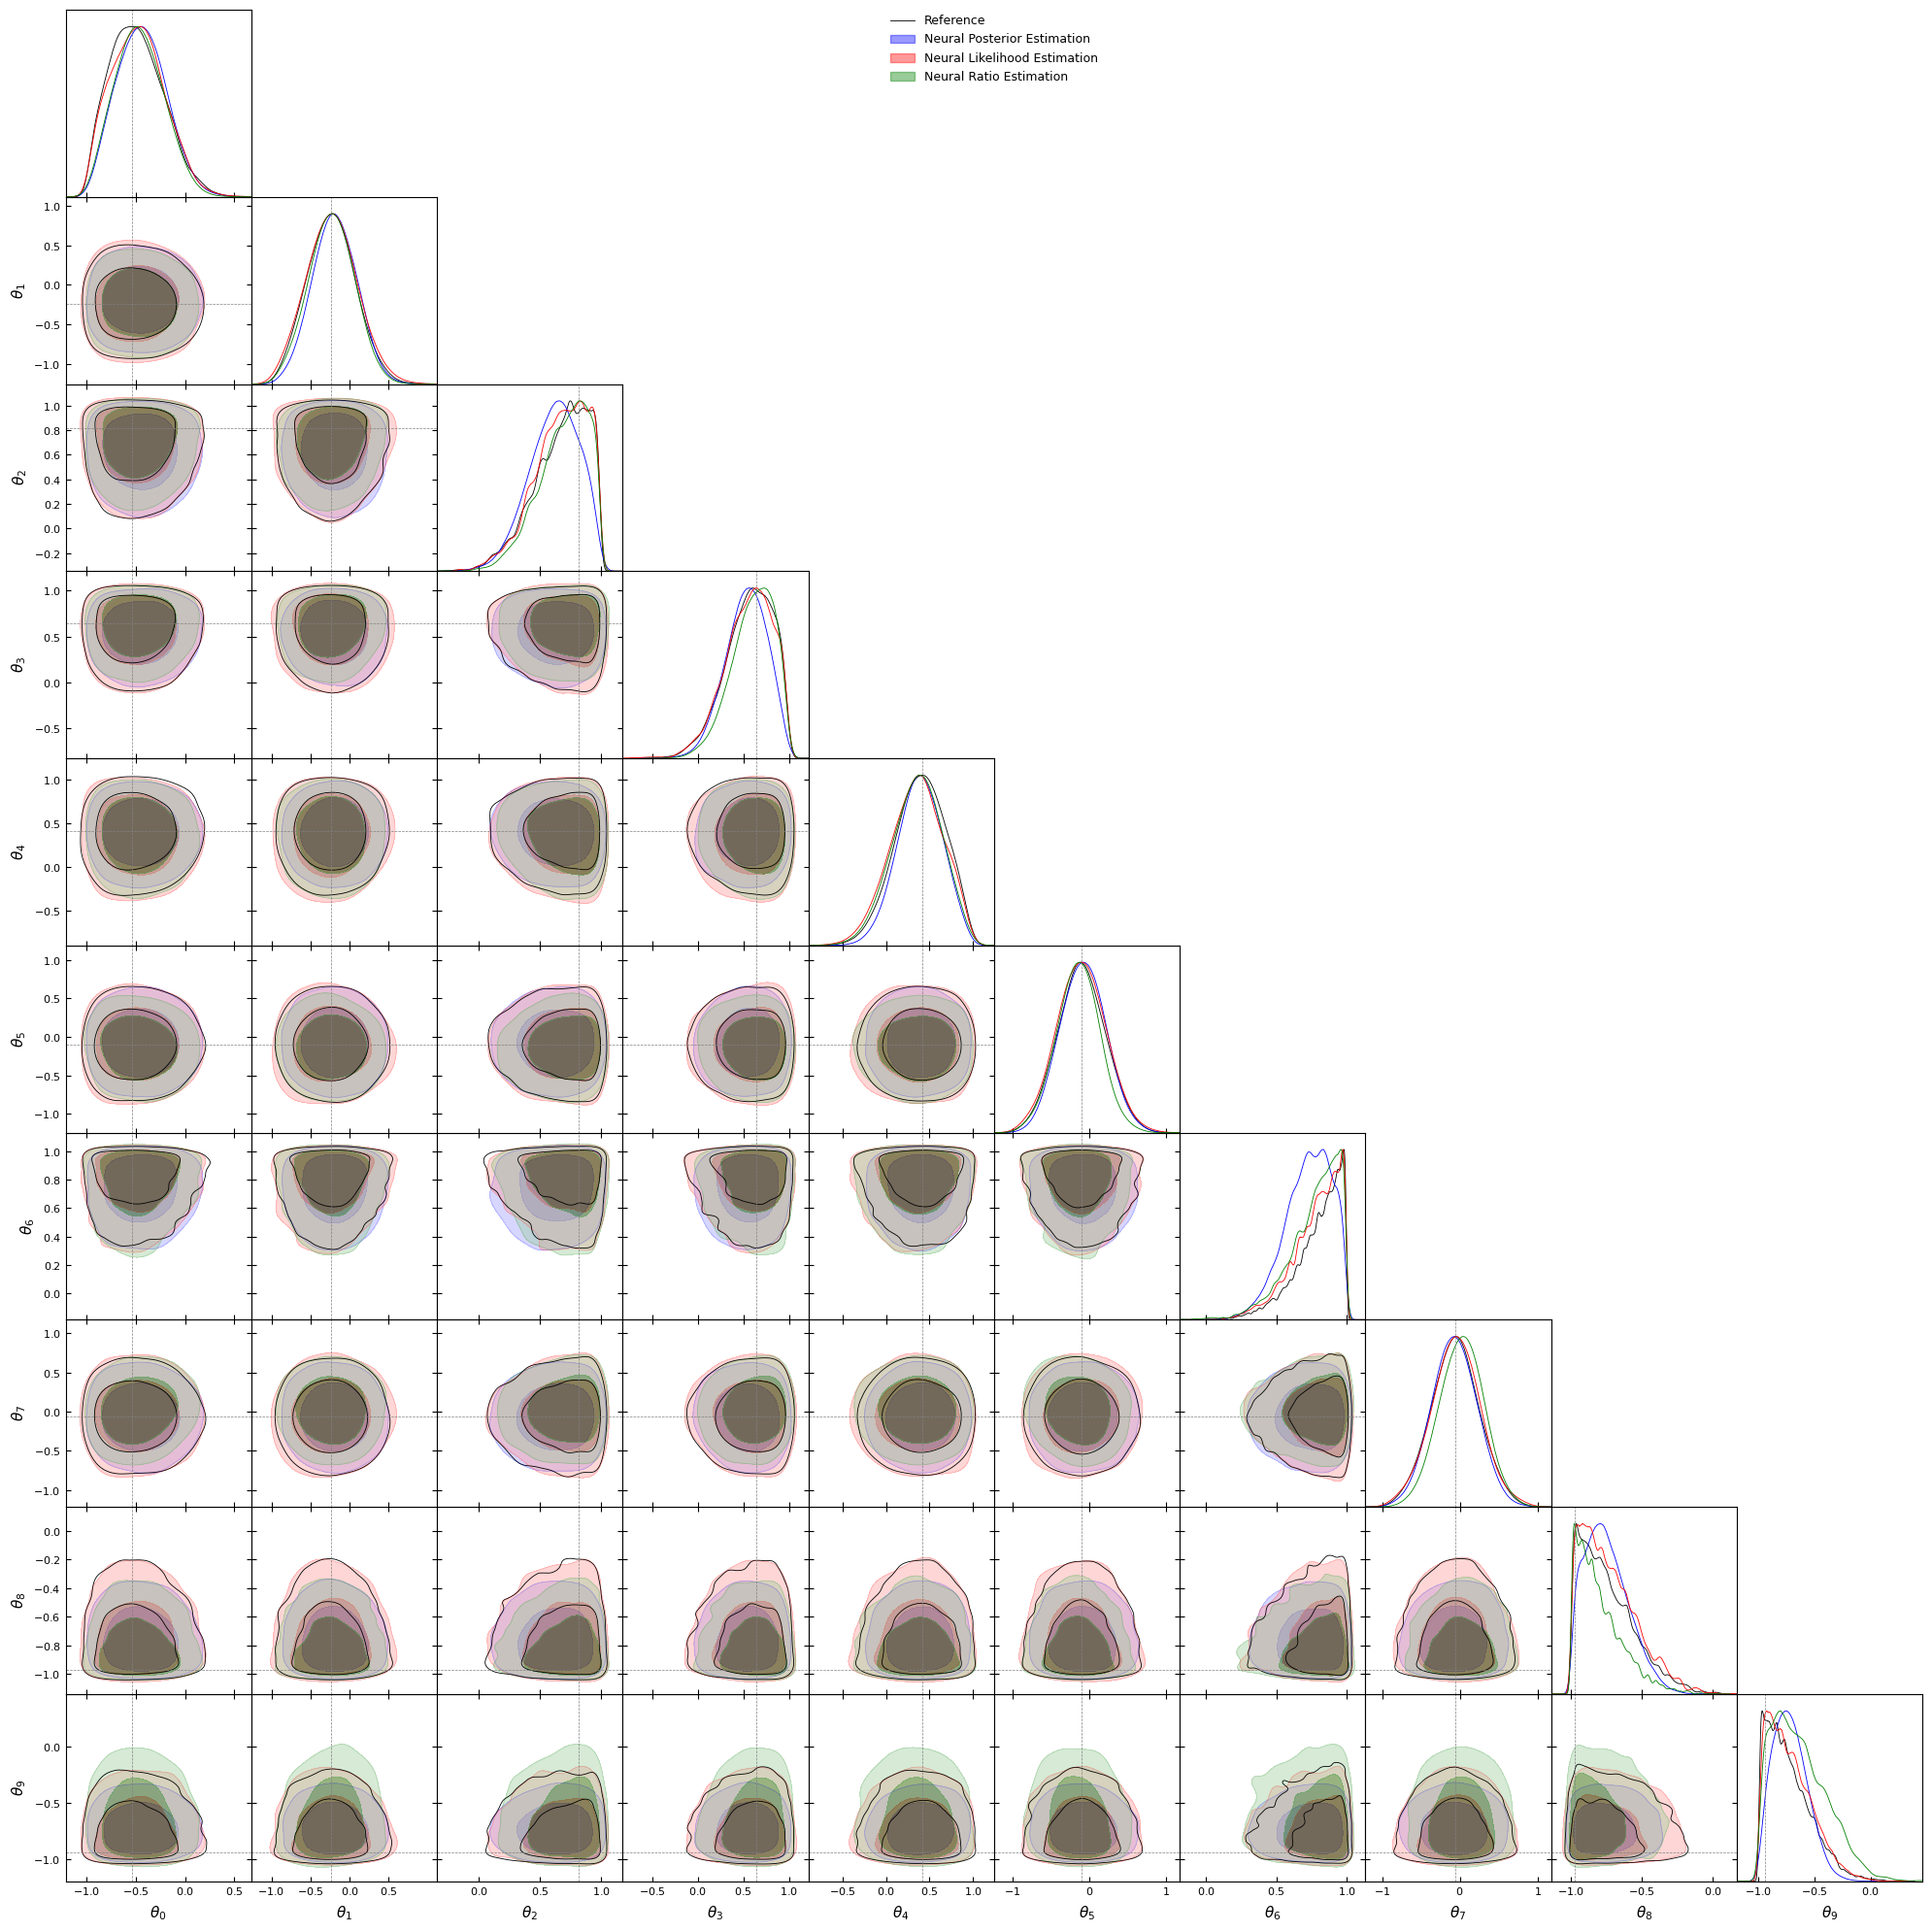

In [44]:
#and compare
nre_samples_gd = MCSamples(samples=nre_samples.cpu().numpy(), names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd, nle_samples_gd, nre_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "Neural Posterior Estimation", "Neural Likelihood Estimation", "Neural Ratio Estimation"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'},
                    {'color': 'green'}
                ],
                contour_colors=['black', 'blue', 'red', 'green'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

Here the target distribution is a Gaussian so it is very simple. Let's now try to apply this methodology with a more complex distribution from `sbibm`.

## 3. Second example: two moons

- Prior: $\mathcal{U}(-1, 1)$
- Simulator: $x|\theta \sim \left[\begin{array}{c} r\cos(\alpha)+0.25 \\ r\sin(\alpha)\end{array}\right]+\left[ \begin{array}{c} -|\theta_1+\theta_2|/\sqrt{2}\\ (-\theta_1+\theta_2)/\sqrt{2} \end{array}\right]$ where $\alpha \sim \mathcal{U}(-\pi/2, \pi/2)$ and $r \sim \mathcal{N}(0.1, 0.01^2)$
- $\theta \in \mathbb{R}^2$, $x\in \mathbb{R}^2$

In [46]:
#Let's fetch the task from sbibm
task = sbibm.get_task('two_moons')
prior = task.get_prior()  #Returns an object that allows to sample from the prior
simulator = task.get_simulator()  #Returns the simulator function
reference_samples = task.get_reference_posterior_samples(num_observation=1)  #Returns the reference samples
observation = task.get_observation(num_observation=1) #Returns the observation
truth = task.get_true_parameters(num_observation=1).flatten() #Returns the true parameters

dim_theta = truth.shape[0]
dim_obs = observation.shape[1]

print(f"Dimension of theta: {dim_theta}")
print(f"Dimension of observation: {dim_obs}")
print(f"True parameters: {truth}")

Dimension of theta: 2
Dimension of observation: 2
True parameters: tensor([-0.8177, -0.5757])


Removed no burn in


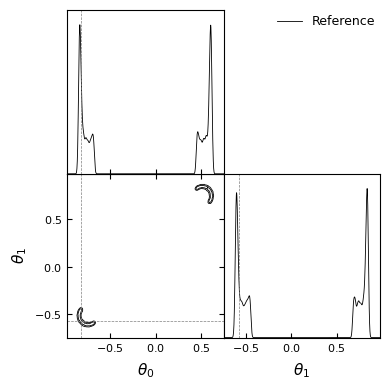

In [50]:
#Let's have a look at the target, we will plot
#distributions using getdist
labels = [rf'\theta_{i}' for i in range(dim_theta)]

reference_samples_gd = MCSamples(samples=reference_samples.numpy(), names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd],
                filled=[False],
                legend_labels=["Reference"],
                line_args=[
                    {'color': 'black'},
                ],
                contour_colors=['black'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

As previously we can train a neural network to sample from the posterior and compare the different methods!

In [52]:
num_samples = 10_000
theta_train = prior(num_samples=num_samples)
x_train = simulator(theta_train)

prior_sbi = BoxUniform(low=-torch.ones(dim_theta), high=torch.ones(dim_theta), device=device)

In [53]:
#Let's start with NPE
inference_npe = NPE(prior=prior_sbi, device=device)
inference_npe = inference_npe.append_simulations(theta=theta_train, x=x_train)
density_estimator_npe = inference_npe.train()

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 162 epochs.

In [54]:
posterior_npe = inference_npe.build_posterior()
print(posterior_npe)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [55]:
npe_samples = posterior_npe.sample((10_000,), x=observation.to(device))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [56]:
npe_samples = npe_samples.cpu().numpy()

Removed no burn in


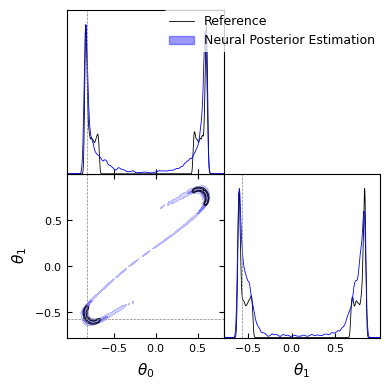

In [59]:
npe_samples_gd = MCSamples(samples=npe_samples, names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd],
                filled=[False],
                legend_labels=["Reference", "Neural Posterior Estimation"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'}
                ],
                contour_colors=['black', 'blue'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

In [60]:
inference_nle = SNLE(prior=prior_sbi, device=device)
inference_nle = inference_nle.append_simulations(theta=theta_train, x=x_train)
density_estimator_nle = inference_nle.train()

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 208 epochs.

In [61]:
posterior_nle = inference_nle.build_posterior(
    mcmc_method="slice_np_vectorized",
    mcmc_parameters={"num_chains": 20,
                    "thin": 1}
)
print(posterior_nle)

Posterior p(θ|x) of type MCMCPosterior. It provides MCMC to .sample() from the posterior and can evaluate the _unnormalized_ posterior density with .log_prob().


In [62]:
nle_samples = posterior_nle.sample((5_000,), x=observation.to(device))

Running vectorized MCMC with 20 chains:   0%|          | 0/10000 [00:00<?, ?it/s]

In [63]:
nle_samples = nle_samples.cpu().numpy()

Removed no burn in


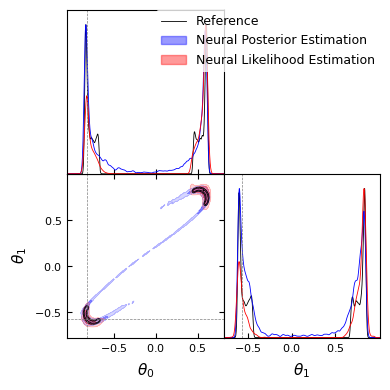

In [64]:
nle_samples_gd = MCSamples(samples=nle_samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd, nle_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "NPE", "NLE"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['black', 'blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

In [66]:
inference_nre = NRE(prior=prior_sbi, device=device)
inference_nre = inference_nre.append_simulations(theta=theta_train, x=x_train)
density_estimator_nre = inference_nre.train()

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 72 epochs.

In [67]:
posterior_nre = inference_nre.build_posterior(
    mcmc_method="slice_np_vectorized",
    mcmc_parameters={"num_chains": 20,
                    "thin": 1}
)
print(posterior_nre)

Posterior p(θ|x) of type MCMCPosterior. It provides MCMC to .sample() from the posterior and can evaluate the _unnormalized_ posterior density with .log_prob().


In [68]:
nre_samples = posterior_nre.sample((5_000,), x=observation.to(device))

Running vectorized MCMC with 20 chains:   0%|          | 0/10000 [00:00<?, ?it/s]

In [69]:
nre_samples = nre_samples.cpu().numpy()

Removed no burn in


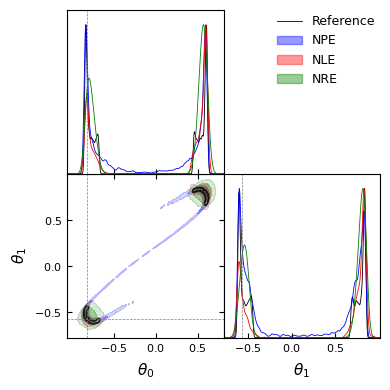

In [71]:
nre_samples_gd = MCSamples(samples=nre_samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([reference_samples_gd, npe_samples_gd, nle_samples_gd, nre_samples_gd],
                filled=[False, True],
                legend_labels=["Reference", "NPE", "NLE", "NRE"],
                line_args=[
                    {'color': 'black'},
                    {'color': 'blue'},
                    {'color': 'red'},
                    {'color': 'green'}
                ],
                contour_colors=['black', 'blue', 'red', 'green'],
                markers={
                    label: val for label, val in zip(labels, truth) 
                }
               )

plt.show()

We can see that on complex distributions, density estimators seems to have better performance than NRE. It's also important to highlight that the performance of the NLE with respect to the NPE depends on the choice of the sampler.

## 4. An example in cosmology

In [31]:
try:
    import jax_cosmo as jc
except:
    %pip install jax-cosmo -q

try:
    import haiku as hk
except:
    %pip install dm-haiku -q

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

jax.devices()

[cuda(id=0)]

In cosmology, we study the expansion history and the matter content of the Universe by computing correlations between different observables (e.g. galaxy positions, galaxy shapes, CMB polarization,...). The correlation can be computed in real space in which case we refer to the 2-point correlation function (2PCF) $\xi(\theta)$ where $\theta$ is the angular distance between two galaxies. The analysis can also be done in Fourier space in which we measure the power spectrum (i.e. the Fourier transform of the 2PCF).

![Weak lensing](https://www.cosmostat.org/wp-content/uploads/2017/06/draufsicht_corr-1.png)

In what follows, we use the package `jax_cosmo` to simulate weak lensing angular power spectra at various cosmology. It will play the role of our dataset to run Implicit Likelihood Inference. The goal is to infer the cosmological parameters that describe the expansion history and matter content of the Universe (go [here](https://en.wikipedia.org/wiki/Lambda-CDM_model) for more details)

In [81]:
#Let's create a cosmology with fiducial parameters
cosmo = jc.Planck15()

fiducial_params = jnp.array([cosmo.Omega_c, cosmo.sigma8]) #These cosmological parameters will be the fiducial parameters
cosmo

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

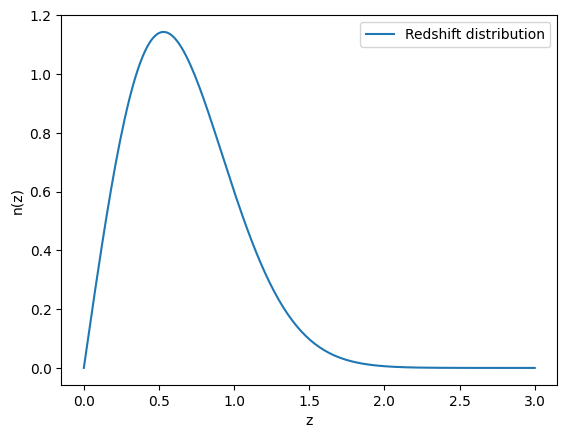

In [22]:
#The power spectrum depends on the cosmology but also on the redshift distribution of galaxies.*
#Let's create a simple redshift distribution
nz = jc.redshift.smail_nz(1., 2., 0.75, gals_per_arcmin2=30)

#and let's have a look at the redshift distribution
z = np.linspace(0, 3, 200)
plt.figure()

plt.plot(z, nz(z), label='Redshift distribution')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.legend()
plt.show()

In [23]:
#We can then use this redshift distribution to predict the power spectrum of cosmic shear/weak lensing
tracer = jc.probes.WeakLensing([nz])

ell = jnp.logspace(1, np.log10(2000), 20) #We will use 20 bins in ell

#Compute the mean and covariance matrix for this cosmology and this tracer
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)

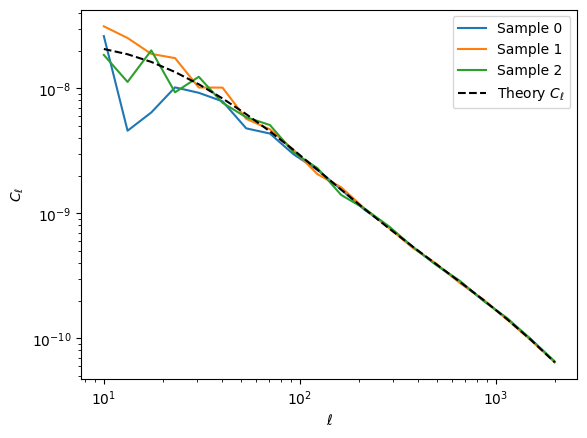

In [24]:
#Let's sample a few Cl's from this distribution
key = jax.random.PRNGKey(42)

plt.figure()

for i in range(3):
    key, _ = jax.random.split(key)
    Cl = jax.random.multivariate_normal(key, mu, cov)
    plt.plot(ell, Cl, label=f'Sample {i}')

plt.plot(ell, mu, label=r'Theory $C_{\ell}$', color='k', linestyle='--')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

As `jax_cosmo` provides the mean and the covariance of the $C_{\ell}$'s, we can create a simulator that returns a power spectrum sampled from the mean and covariance returned by `jax_cosmo`. In this notebook, we will only focus on the parameters $\Omega_c$, the dark matter content of the Universe, and $\sigma_8$, which quantifies the "clumpiness" of the Universe.

In [63]:
#Let's define the simulator
@jax.jit #This is a jax decorator that makes the function faster
def simulator(params, key): #with jax a key must be given to be able to generate random numbers
    cosmo = jc.Planck15(Omega_c=params[0], sigma8=params[1])
    mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], f_sky=0.125)
    Cl = jax.random.multivariate_normal(key, mu, cov)
    return Cl

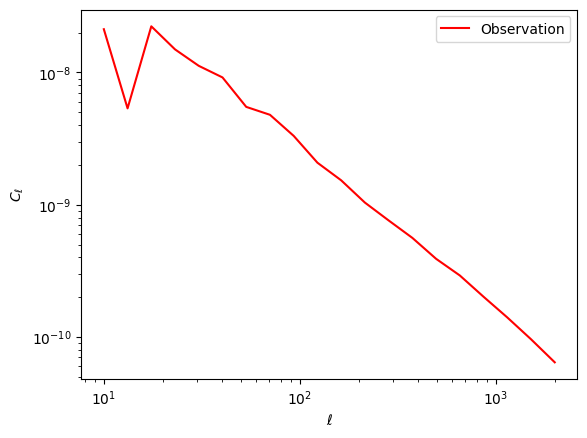

In [64]:
#Let's fetch an observation from the simulator
key = jax.random.PRNGKey(0)
observation = simulator(fiducial_params, key)

plt.figure()

plt.plot(ell, observation, label='Observation', color='red')

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()


In [36]:
#Let's generate the training set. We first need to collect cosmological parameters sampled from the prior.
#We will use a uniform prior on Omega_c and sigma8
dim_theta = 2
dim_obs = 20

num_train = 10_000

thetas_train = stats.qmc.LatinHypercube(d=2).random(num_train) #We use LatinHypercube to optimally sample the parameter space
thetas_train = stats.qmc.scale(thetas_train, np.array([0.0, 0.0]), np.array([1.0, 1.5]))

x_train = []
master_key = jax.random.PRNGKey(42)
for th in tqdm(thetas_train):
    key, master_key = jax.random.split(key)
    x_train.append(simulator(th, key))
x_train = jnp.array(x_train)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:18<00:00, 72.45it/s]


In [41]:
#We are going to use the `sbi` library that uses torch so we have to convert the data to torch
theta_train = torch.tensor(np.array(thetas_train), dtype=torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)

In [44]:
#And put the data on the GPU if needed
theta_train = theta_train.to(device)
x_train = x_train.to(device)

Now that the dataset is ready, we can use `sbi` to perform the Implicit Likelihood Inference.

In [45]:
prior_sbi = BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([1.0, 1.5]), device=device)

In [46]:
#Let's start with NPE
inference_npe = NPE(prior=prior_sbi, device=device)
inference_npe = inference_npe.append_simulations(theta=theta_train, x=x_train)
density_estimator_npe = inference_npe.train()

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/npe/npe_base.py:157: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 333 epochs.

In [47]:
posterior_npe = inference_npe.build_posterior()
print(posterior_npe)

Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


In [93]:
observation = torch.tensor(np.array(observation), dtype=torch.float32)

npe_samples = posterior_npe.sample((10_000,), x=observation.to(device))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [94]:
npe_samples = npe_samples.cpu().numpy() #Let's send it back to the CPU

Removed no burn in


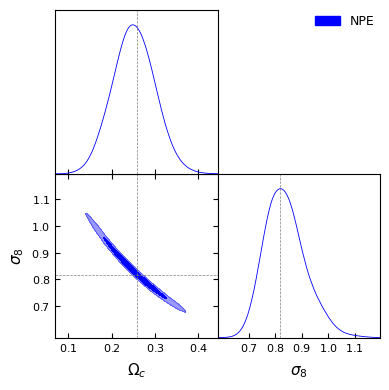

In [95]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8']

npe_samples_gd = MCSamples(samples=npe_samples, names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd],
                filled=[True],
                legend_labels=["NPE"],
                line_args=[
                    {'color': 'blue'},
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params) 
                }
               )

plt.show()


We can see that $\Omega_c$ and $\sigma_8$ are degenerate. In cosmology, we usually look at the value of $S_8=\sigma_8 \sqrt{\Omega_m/0.3}$.

In [96]:
get_S_8 = lambda Omega_c, sigma8: sigma8 * ((Omega_c+cosmo.Omega_b) / 0.3)**0.5
get_Omega_m = lambda Omega_c: Omega_c + cosmo.Omega_b

fiducial_params = jnp.array([cosmo.Omega_c, cosmo.sigma8, get_S_8(cosmo.Omega_c, cosmo.sigma8), get_Omega_m(cosmo.Omega_c)]) #Add S8 and Omega_m to the fiducial

In [97]:
npe_S_8 = get_S_8(npe_samples[:, 0], npe_samples[:, 1])
npe_Omega_m = get_Omega_m(npe_samples[:, 0])
npe_samples = np.column_stack((npe_samples, npe_S_8, npe_Omega_m))

Removed no burn in


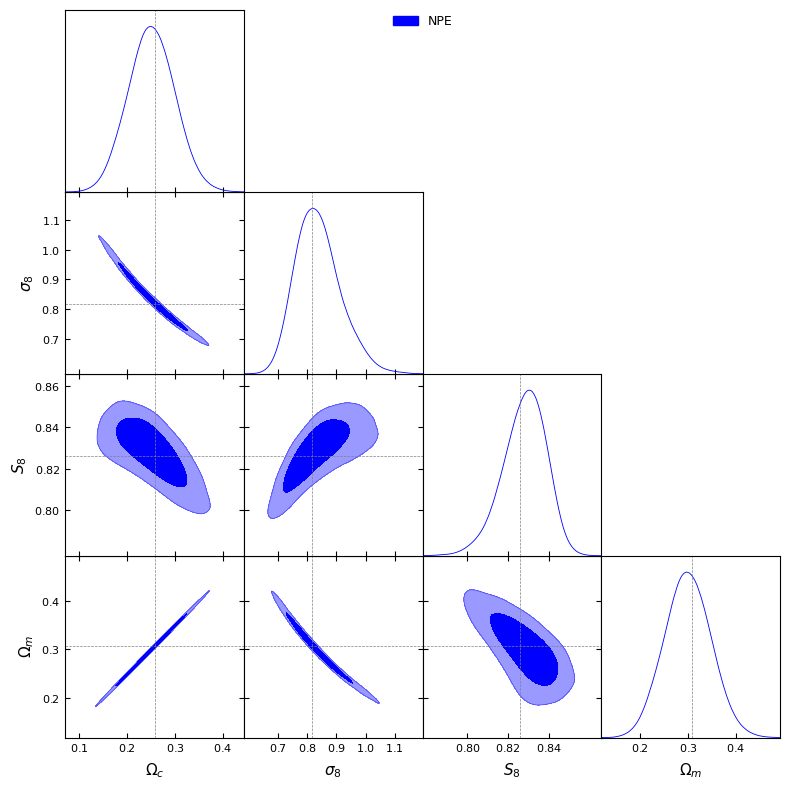

In [98]:
#And have a look at the posterior
labels = [r'\Omega_c', r'\sigma_8', r'S_8', r'\Omega_m']

npe_samples_gd = MCSamples(samples=npe_samples, names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd],
                filled=[True],
                legend_labels=["NPE"],
                line_args=[
                    {'color': 'blue'},
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params) 
                }
               )

plt.show()

In [99]:
#Let's now try with NLE
inference_nle = SNLE(prior=prior_sbi, device=device)
inference_nle = inference_nle.append_simulations(theta=theta_train, x=x_train)
density_estimator_nle = inference_nle.train()

/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Data x has device 'cuda:0'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/sacha/anaconda3/envs/jaxili/lib/python3.10/site-packages/sbi/inference/trainers/base.py:278: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


 Neural network successfully converged after 272 epochs.

In [100]:
posterior_nle = inference_nle.build_posterior(
    mcmc_method="slice_np_vectorized",
    mcmc_parameters={"num_chains": 20,
                    "thin": 1}
)
print(posterior_nle)

Posterior p(θ|x) of type MCMCPosterior. It provides MCMC to .sample() from the posterior and can evaluate the _unnormalized_ posterior density with .log_prob().


In [101]:
nle_samples = posterior_nle.sample((5_000,), x=observation.to(device))

Running vectorized MCMC with 20 chains:   0%|          | 0/10000 [00:00<?, ?it/s]

In [102]:
nle_samples = nle_samples.cpu().numpy()

In [103]:
nle_S_8 = get_S_8(nle_samples[:, 0], nle_samples[:, 1])
nle_Omega_m = get_Omega_m(nle_samples[:, 0])
nle_samples = np.column_stack((nle_samples, nle_S_8, nle_Omega_m))

Removed no burn in


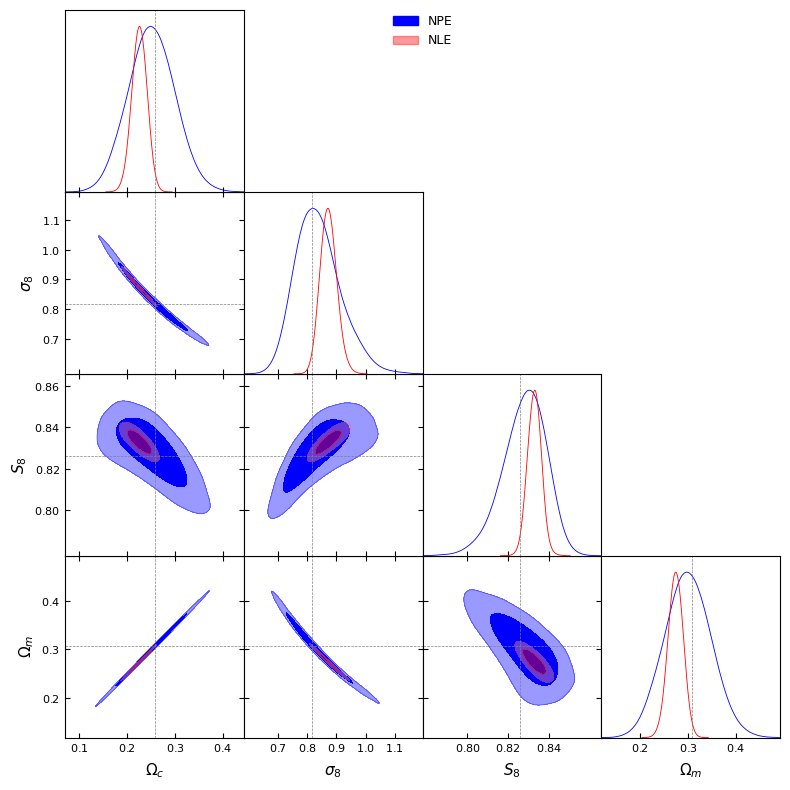

In [104]:
nle_samples_gd = MCSamples(samples=nle_samples, names=labels,
                                 labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([npe_samples_gd, nle_samples_gd],
                filled=[True],
                legend_labels=["NPE", "NLE"],
                line_args=[
                    {'color': 'blue'},
                    {'color': 'red'}
                ],
                contour_colors=['blue', 'red'],
                markers={
                    label: val for label, val in zip(labels, fiducial_params) 
                }
               )

plt.show()